# Content filtering

In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import traceback
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import statsmodels.api as sm
from statsmodels.api import OLS

from scipy import sparse

import pickle

from IPython.display import display, HTML, Markdown

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

from surprise import Dataset, Reader
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, \
SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline

from recommender import plot_cm, get_results, show_results, IO, show_summaries, get_X
from recommender import ModeClassifier, BaselineMean, BaselineRegression, ALS1, ALS2, RS_surprise, RS_sklearn



In [2]:
city = 'Champaign'
fig_dir = 'figs/modeling/{}/'.format(city)
data_dir = 'data/{}/'.format(city)

dfb = pd.read_pickle(data_dir + 'business.pkl')
dfu = pd.read_pickle(data_dir + 'user.pkl')

X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()

(X_train, column_names) = get_X(X_train, dfb, dfu, return_columns=True)
X_test = get_X(X_test, dfb, dfu)
X_cv = get_X(X_cv, dfb, dfu)

# IO(data_dir + '05_data_split.pkl').to_pickle([X_train, y_train, X_test, y_test, X_cv, y_cv])

del dfb
del dfu

## Introduction

By merging the user.csv and business.csv through the user_id and business_id in review, we get a complete X (predictor) matrix. From EDA we find that review score is strongly associated with some of the properties of users, or can be differented greatly on some attributed of restaurants. Therefore, we decide to build content filtering models, including linear regression, ridge regression, logistic regression and random forest regressor.
<br><br><br>

## Content filtering models

### Feature Selection
Before building the model, we preprocess the data by dropping certain uncorrelated variables, such as longitutde, latitude and postal code, as well as some string varibles, such as names, friends and so on. We deal with the missing values with imputation. Also, we didn't include all the over 100 variables into consideration, because some of them don't have strong and clear relationships with review score but increase the multicollinearity and sparsity of predictor matrix.

Instead, we pick 51 important predictors through EDA, which shows some relationships with review stars. For example, as shown in the EDA, review stars have various distributions on different dummy attributes of restaurant, such as different bestnight, music, food restriction, ambience and "good for" emphasis. Also, some of the categories in categorical attributes of restaurant show different patterns with others. Instead of taking dummy, we group by the different pattern and encode the categories according to their effect on review stars based on EDA. For instance, for attribute "RestaurantAttire", only "formal" appear a different pattern compared with other categories in the box plot. So we only encode it with 1 and other categories with 0.
For properties of users, we include variables that shows strong relationships with review stars, such as users'average star, fans, review count etc. 

Here we assume: 
1. average ratings of user and restaurants are always available;

2. the average ratings in the user and business tables wouldn't deviate a lot from the averages we learn from data in the training set; thus it would be valid to include average rating from 2 tables as features in our model.

### Linear regression

First of all, we perform general OLS to have a preliminary understanding of content filtering. Linear Regression result already indicates a great performance on test set compared with Baseline (Regression) model. Similar criterion values on both training and test set means including more attributes and using content filtering could fix overfitting well. In the following, we would implement certain models we learn from class to see if we could improve it.

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Linear regression,0.028,1.0772,1.0973,0.4341,0.4279


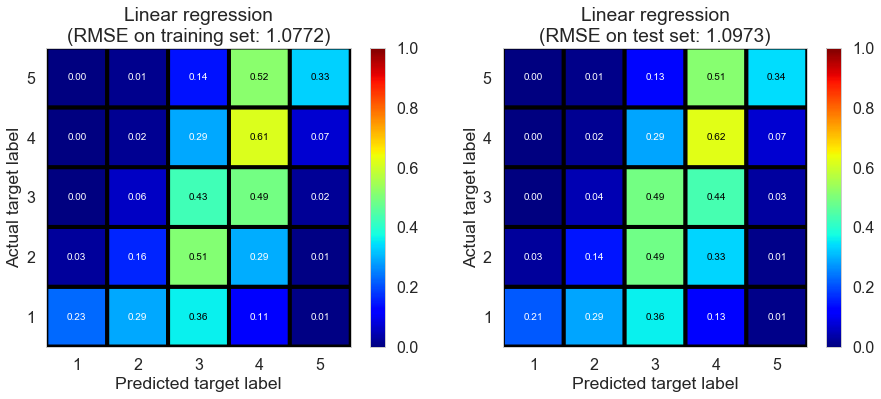

In [6]:
es = RS_sklearn(estimator=LinearRegression()).fit(X_train, y_train)
model_name = 'Linear regression'

results = get_results(es, X_train, y_train, X_test, y_test, X_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train, y_train, X_test, y_test, results=results, print_=False, plot=True, \
            show_cv=False, show_title=False);

<br><br><br>

### Ridge regression

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Ridge regression,0.064,1.0772,1.0973,0.4341,0.4279


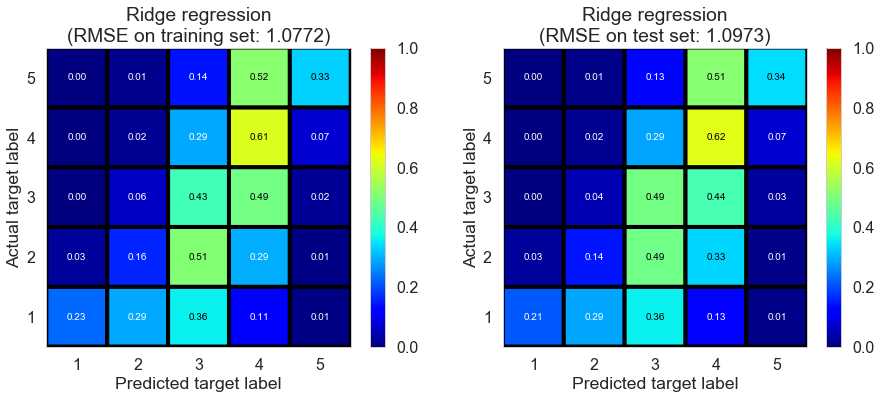

In [5]:
es = RS_sklearn(estimator=RidgeCV()).fit(X_train, y_train)
model_name = 'Ridge regression'

results = get_results(es, X_train, y_train, X_test, y_test, X_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train, y_train, X_test, y_test, results=results, print_=False, plot=True, \
            show_cv=False, show_title=False);

<br><br><br>

### Lasso regression

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Lasso regression,0.256,1.0786,1.0961,0.4326,0.4291


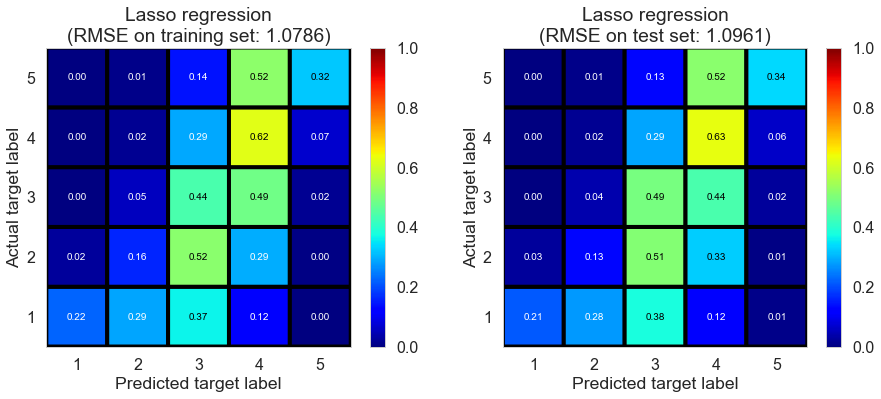

In [8]:
es = RS_sklearn(estimator=LassoCV()).fit(X_train, y_train)
model_name = 'Lasso regression'

results = get_results(es, X_train, y_train, X_test, y_test, X_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train, y_train, X_test, y_test, results=results, print_=False, plot=True, \
            show_cv=False, show_title=False);

Regression with regularization doesn't seem to improve a lot from OLS. Reason might be we already select important predictors. In fact, we try to use the complete predictors matrix (over 100 predictors) and try with RidgeCV/LassoCV. Results seem to be even worse. Manually selecting predictors might be better in interpretation and prediction. So in the following we keep using the selected predictor matrix rather than keep trying dimension reduction model such as stepwise/PCA.
<br><br><br>

### Logistic regression

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Logistic regression,2.6832,1.3889,1.4052,0.0591,0.0618


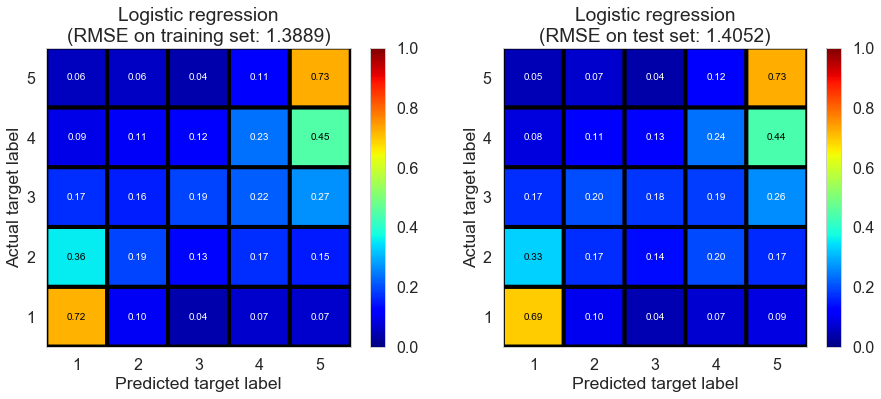

In [9]:
es = RS_sklearn(estimator=LogisticRegressionCV(class_weight='balanced')).fit(X_train, y_train)
model_name = 'Logistic regression'

results = get_results(es, X_train, y_train, X_test, y_test, X_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train, y_train, X_test, y_test, results=results, print_=False, plot=True, \
            show_cv=False, show_title=False);

Besides regression model, we could also implement classification model. Here we try logistic regression with cross validation. Classification accuracy seem to improve compared with regression model, but RMSE get worse on both training and test set. As a matter of fact, we consider RMSE as a more important assessment because we had better not to punish at the same scale between predicting 5 as 1 and predicitng 5 as 4. This also explains why classification model doesn't work as well as regression model due to the same punishment scale in loss function. So we no longer consider other classification models such as SVM etc.
<br><br><br>

### Random forest regressor

We come back to regression model and try random forest regressor model. We choose appropriate parameters, including n_estimator and max_depth, through cross validation (GridSearchCV). Results show that this model performs better in RMSE and $R^2$ on both training and test set. Therefore, it provides us with some ideas on implementing ensemble models.

In [10]:
ns = list(range(1, X_train.shape[1]+1))
m32 = [RandomForestRegressor(n_estimators=n, max_features='auto').fit(X_train, y_train) for n in ns]

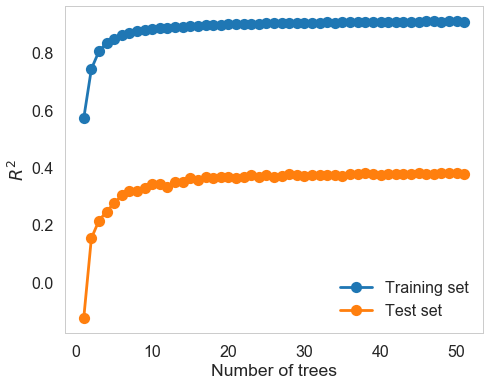

In [11]:
s32_train = [m.score(X_train, y_train) for m in m32]
s32_test = [m.score(X_test, y_test) for m in m32]
plt.figure(figsize=(7.5, 6))
plt.plot(ns, s32_train, 'o-', label='Training set');
plt.plot(ns, s32_test, 'o-', label='Test set');
plt.legend();
plt.xlabel('Number of trees');
plt.ylabel('$R^2$');

In [12]:
n_trees = 50
ns_depth = list(range(1, X_train.shape[1]+1))
gs34 = GridSearchCV(RandomForestRegressor(n_estimators=n_trees), param_grid={'max_depth':ns_depth}, cv=5).fit(X_train, y_train)

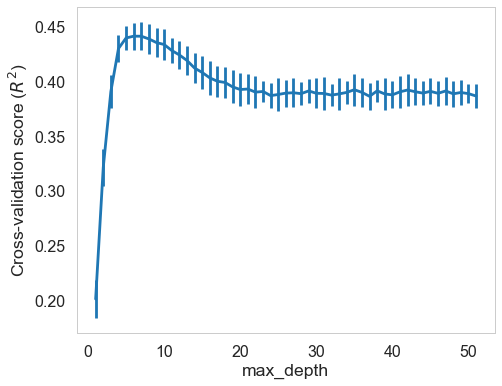

In [13]:
n_depth_best = ns_depth[np.argmax(gs34.cv_results_['mean_test_score'])]
#print('The optimal value for max_depth is {}.'.format(n_depth_best))
plt.figure(figsize=(7.5, 6))
plt.errorbar(ns_depth, gs34.cv_results_['mean_test_score'], gs34.cv_results_['std_test_score'], fmt='')
plt.xlabel('max_depth');
plt.ylabel('Cross-validation score ($R^2$)');

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Random forest,1.1121,1.0265,1.0858,0.486,0.4398


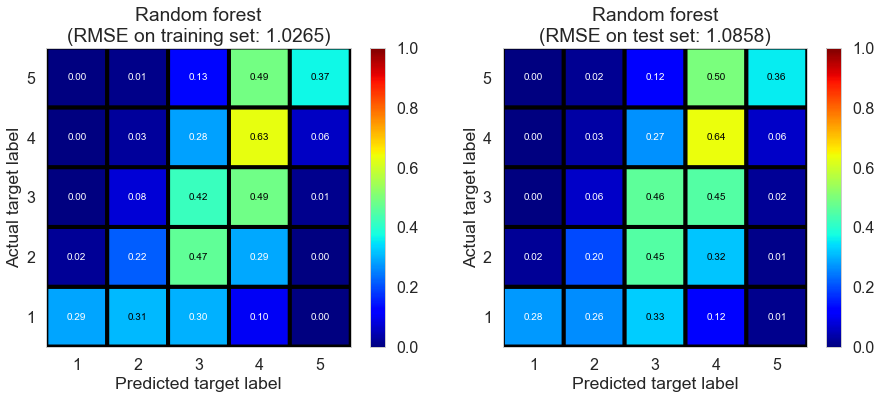

In [3]:
es = RS_sklearn(estimator=RandomForestRegressor(n_estimators=50, max_depth=7)).fit(X_train, y_train)
model_name = 'Random forest'

results = get_results(es, X_train, y_train, X_test, y_test, X_cv, y_cv)

show_summaries([model_name], [results], [True]);

show_results(es, model_name, X_train, y_train, X_test, y_test, results=results, print_=False, plot=True, \
            show_cv=False, show_title=False);

<br><br><br>

## Potential Drawbacks

We investigated the significance of each predictor in the linear regression model, and found something fishy.

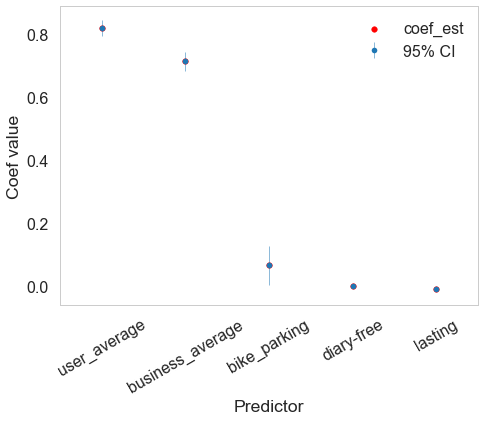

In [10]:
X_subset = sm.add_constant(X_train)
ols_sm = sm.OLS(y_train, X_subset)
fit_sm = ols_sm.fit()
#print(fit_sm.summary())


is_significant = fit_sm.pvalues < 0.05
sig_vars = [i for i in range(len(is_significant)) if is_significant[i]]
#print('There are {} statistically significant coefficients (p < 0.05):'.format(len(sig_vars)))

sig_b = []

for i in range(len(sig_vars)-1):
    row={}
    row["predictor"] = column_names[sig_vars[i+1] - 1]
    row["coef"] = fit_sm.params[sig_vars[i+1]]
    row["CI 2.5"] = fit_sm.conf_int()[sig_vars[i+1]][0]
    row["CI 97.5"] = fit_sm.conf_int()[sig_vars[i+1]][1]
    sig_b.append(row)

sig_b_df = pd.DataFrame(sig_b)
sig_b_df = sig_b_df.sort_values("coef", ascending=False)
sig_b_df[["predictor","coef","CI 2.5","CI 97.5"]].head()

plt.figure(figsize=(7.5, 5.5))

plt.errorbar(range(sig_b_df.shape[0]), 0.5*sig_b_df["CI 97.5"]+0.5*sig_b_df["CI 2.5"],  \
             yerr=0.5*(sig_b_df["CI 97.5"]-sig_b_df["coef"])+0.5*(sig_b_df["coef"]-sig_b_df["CI 2.5"]), \
             fmt='.', marker=None, elinewidth=0.5, label="95% CI");
plt.scatter(range(sig_b_df.shape[0]), sig_b_df["coef"], color='red', label="coef_est", marker='.');
plt.xlim((-0.5, sig_b_df.shape[0]-0.5));
plt.xticks(range(5), ['user_average', 'business_average'] + [i for i in sig_b_df['predictor'].values[2:]], rotation=30);
plt.xlabel("Predictor");
plt.ylabel("Coef value");
plt.legend();

The assumption to include average stars as features might be fishy.

1. According to the following graph of importance of coefficients, 5 out of our 51 predictors in the model are significant / important: users' average stars, restaurants' average stars, restaurants' bike parking, restaurants' food restriction is diary-free,  and years users started to use yelp. We don't feel surprise to see the first two predictors since they play a main role in all of our models. In addition, the other predictors with coefficients slightly higher than 0 are also apparent indicators of high review score according to EDA. So the most important variables in this model are users' average stars and restaurants' average stars.

2. However, a majority of users or restaurants have only sent / received one review score. Therefore, when we make prediction based on these predictors, they are not always available.

3. Also, it the amount of review stars that users our restaurants have only sent / received is small, then the known average ratings in practice might be different from the average rating in the current two tables. Therefore, it might not be reasonable to directly using the average ratings in the two tables as the average ratings features we want.